In [1]:
import matplotlib.pyplot as plt
import numpy as np

import optical_gating_analysis as OG
from tqdm import tqdm


from scipy.stats import gaussian_kde

In [2]:
import matplotlib

matplotlib.rcParams.update(
    {
        # Adjust to your LaTex-Engine
        "pgf.texsystem": "xelatex",
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
        "axes.unicode_minus": False,
    }
)

matplotlib.rcParams['figure.figsize'] = (9, 9)

In [3]:
oog = OG.BasicOpticalGating()
oog.sequence_manager.set_source(r"E:\data\my data\Arrhythmic imaging April 2024 2\2024-04-26 17.30.44 vid bloodless 200fps\Allied Vision Technologies GS650 0001f61c\*tif")
oog.sequence_manager.set_reference_sequence(r"E:\data\my data\Arrhythmic imaging April 2024 2\2024-04-26 17.30.44 vid bloodless 200fps\ref-frames-2024-04-26-17.29.51\*tif")
oog.sequence_manager.reference_period = 73.106274
oog.run()

Setting source to E:\data\my data\Arrhythmic imaging April 2024 2\2024-04-26 17.30.44 vid bloodless 200fps\Allied Vision Technologies GS650 0001f61c\*tif
Loading reference sequence from E:\data\my data\Arrhythmic imaging April 2024 2\2024-04-26 17.30.44 vid bloodless 200fps\ref-frames-2024-04-26-17.29.51\*tif


Getting phases: 100%|██████████| 37970/37970 [00:00<00:00, 88768.41it/s]


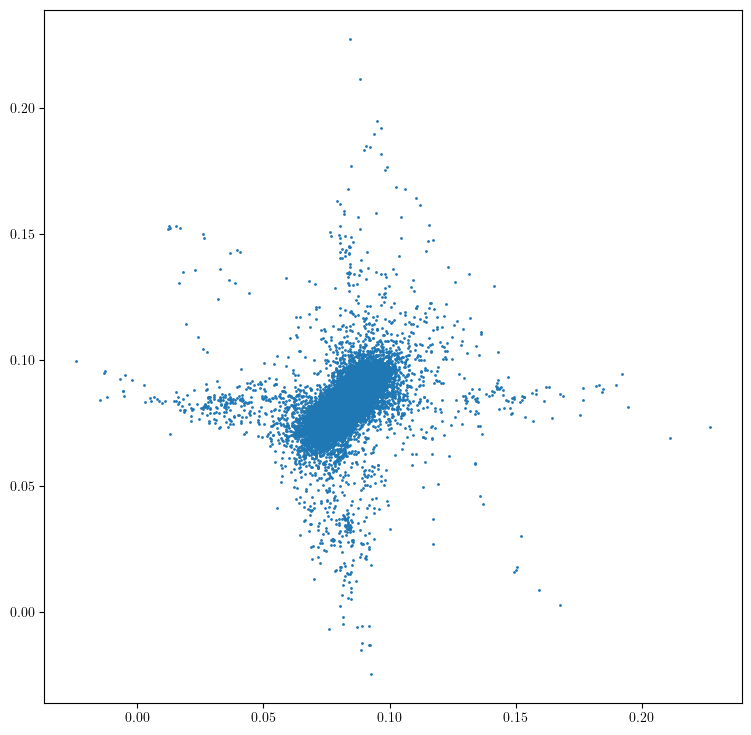

In [4]:
plt.scatter(oog.delta_phases[0:-1], oog.delta_phases[1::], s=1)
plt.axis("equal")
plt.show()

In [5]:
x = oog.delta_phases[0:-1]
y = oog.delta_phases[1::]

xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()

X, Y = np.mgrid[xmin:xmax:400j, ymin:ymax:400j]

positions = np.vstack([X.ravel(), Y.ravel()])

values = np.vstack([x, y])

kernel = gaussian_kde(values)

Z = np.reshape(kernel(positions).T, X.shape)

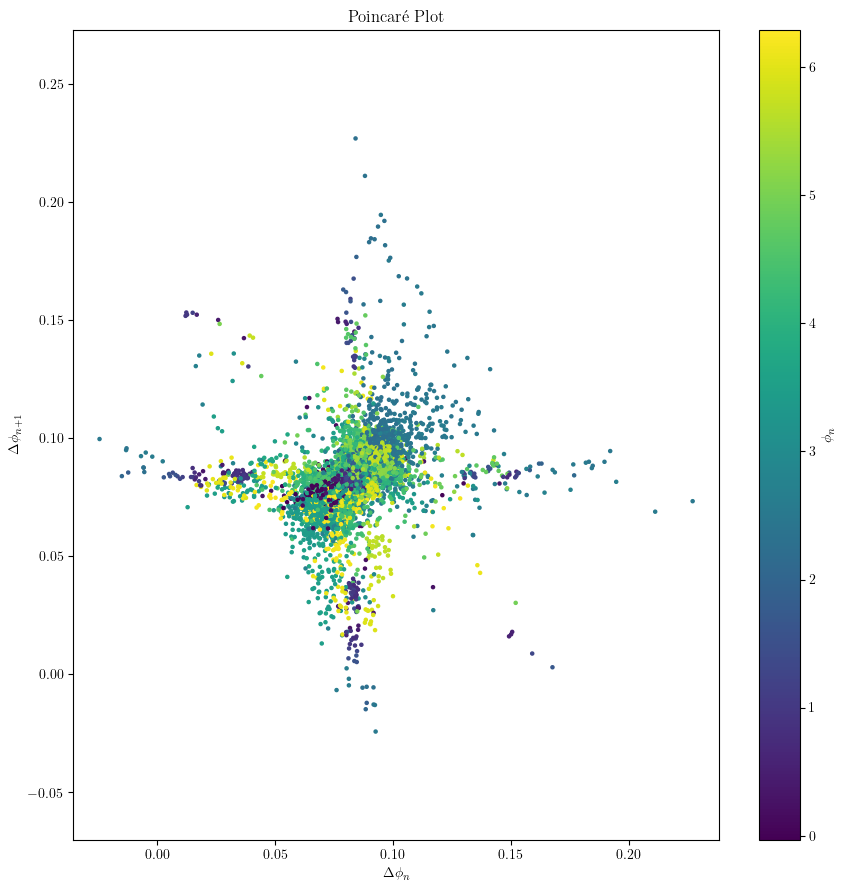

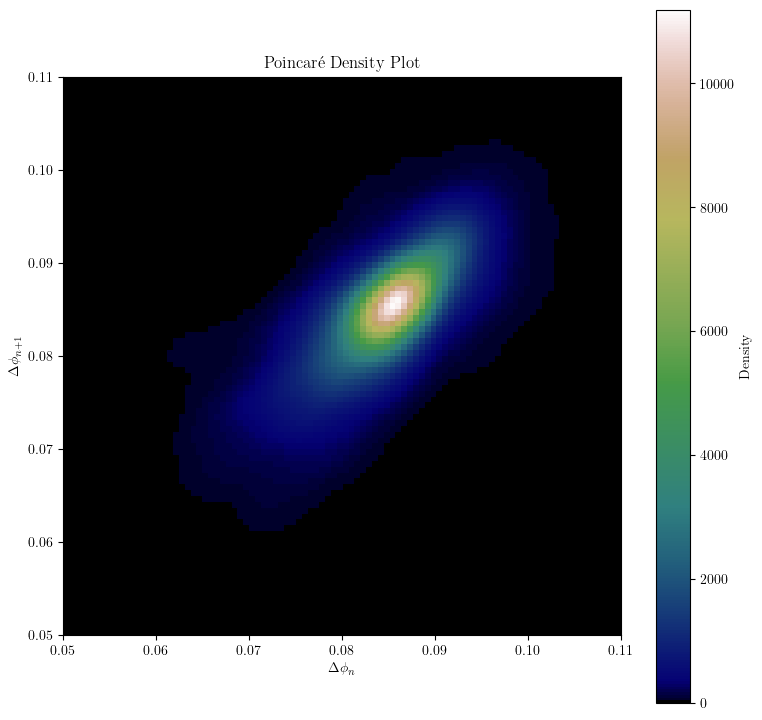

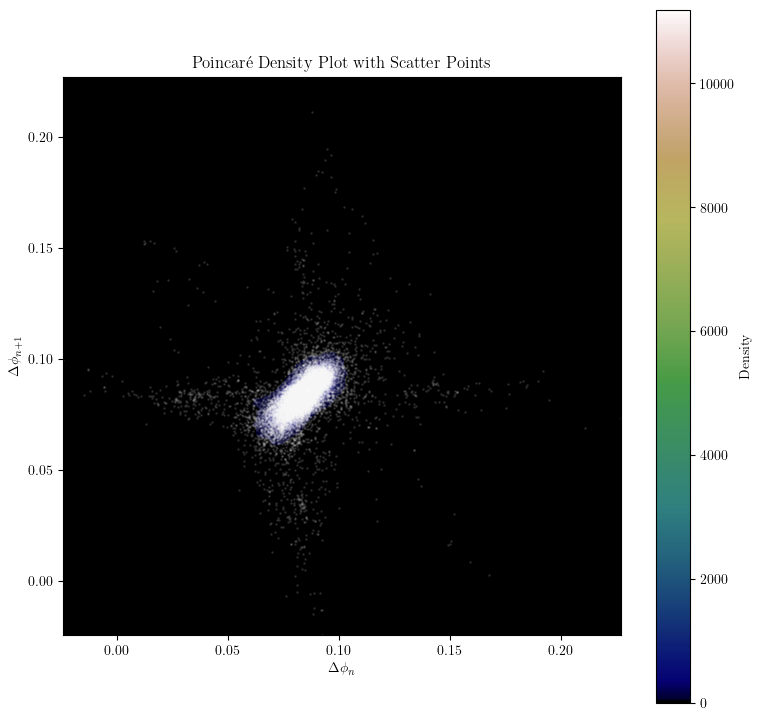

In [6]:
plt.figure(figsize = (9,9))
plt.title("Poincaré Plot")
plt.scatter(oog.delta_phases[0:-1], oog.delta_phases[1::], s = 5, c = oog.phases[1:-1])
plt.axis("equal")
plt.xlabel(r"$\Delta \phi_{n}$")
plt.ylabel(r"$\Delta \phi_{n+1}$")
plt.colorbar(label = "$\phi_n$")
plt.axis("equal")
plt.tight_layout()
plt.show()

plt.figure(figsize = (9,9))
plt.title("Poincaré Density Plot")
plt.imshow(Z, origin = "lower", cmap = "gist_earth", extent = [xmin, xmax, ymin, ymax], interpolation = "none")
plt.xlabel(r"$\Delta \phi_{n}$")
plt.ylabel(r"$\Delta \phi_{n+1}$")
plt.colorbar(label = "Density")
plt.xlim(0.05, 0.11)
plt.ylim(0.05, 0.11)
plt.show()

plt.figure(figsize = (9,9))
plt.title("Poincaré Density Plot with Scatter Points")
plt.imshow(Z, origin = "lower", cmap = "gist_earth", extent = [xmin, xmax, ymin, ymax], interpolation = "none")
plt.colorbar(label = "Density")
plt.scatter(oog.delta_phases[0:-1], oog.delta_phases[1::], s = 1, c = "white", alpha = 0.1)
plt.xlabel(r"$\Delta \phi_{n}$")
plt.ylabel(r"$\Delta \phi_{n+1}$")
plt.show()

In [62]:
i_prev = 0
beat_indices = []
for i in range(1, oog.phases.shape[0]):
    if (oog.phases[i] - oog.phases[i - 1]) < -np.pi:
        if abs(i_prev - i) > 5:
            beat_indices.append(i)
            i_prev = i

gradients = []
from scipy.optimize import curve_fit
for i in range(len(beat_indices) - 2):
    xs = range(beat_indices[i], beat_indices[i+2])
    ys = oog.unwrapped_phases[beat_indices[i]:beat_indices[i+2]]
    popt, popc = curve_fit(lambda x, a, b: a * x + b, xs, ys)
    gradients.append(popt[0])

gradients = np.array(OG.radsperframe_to_bps(np.array(gradients),120))

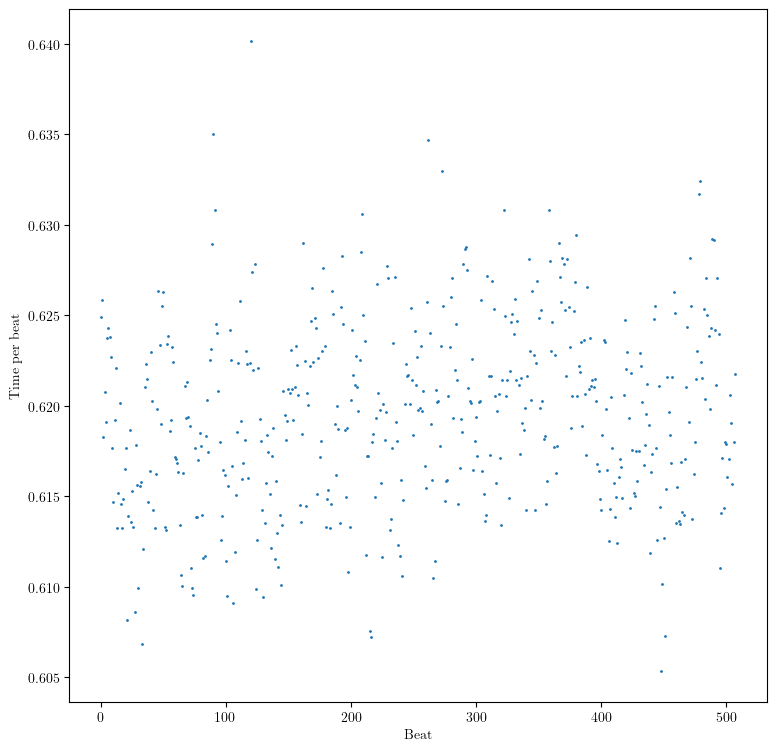

In [75]:
plt.scatter(range(len(gradients)), 1/gradients, s = 1)
plt.xlabel("Beat")
plt.ylabel("Time per beat")
plt.show()

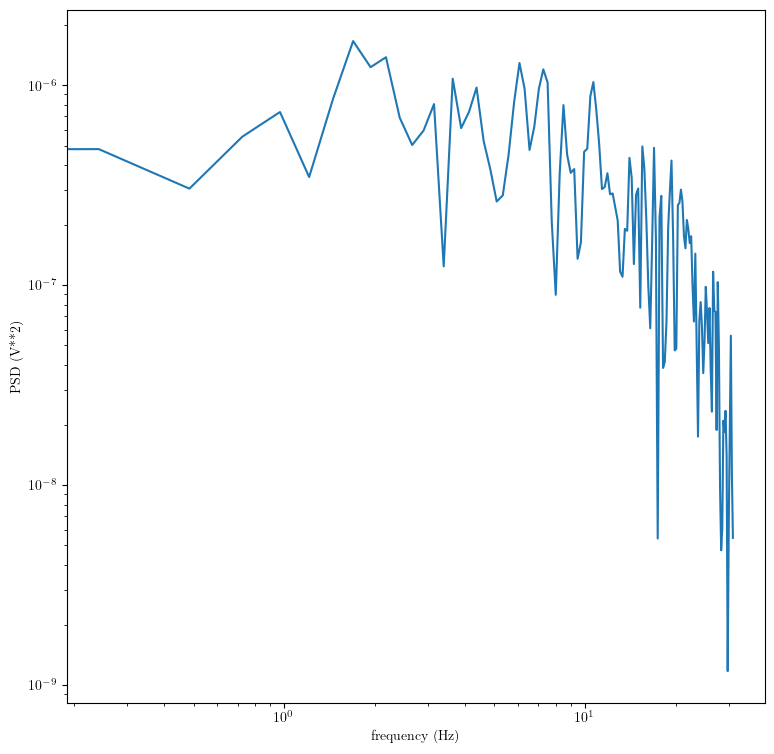

In [80]:
from scipy import signal
fs = 0.62 * 100
f, Pxx_den = signal.welch(1/gradients, fs, nperseg=256, scaling = "spectrum")
plt.semilogy(f, Pxx_den)
plt.xscale("log")
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD (V**2)')
plt.show()


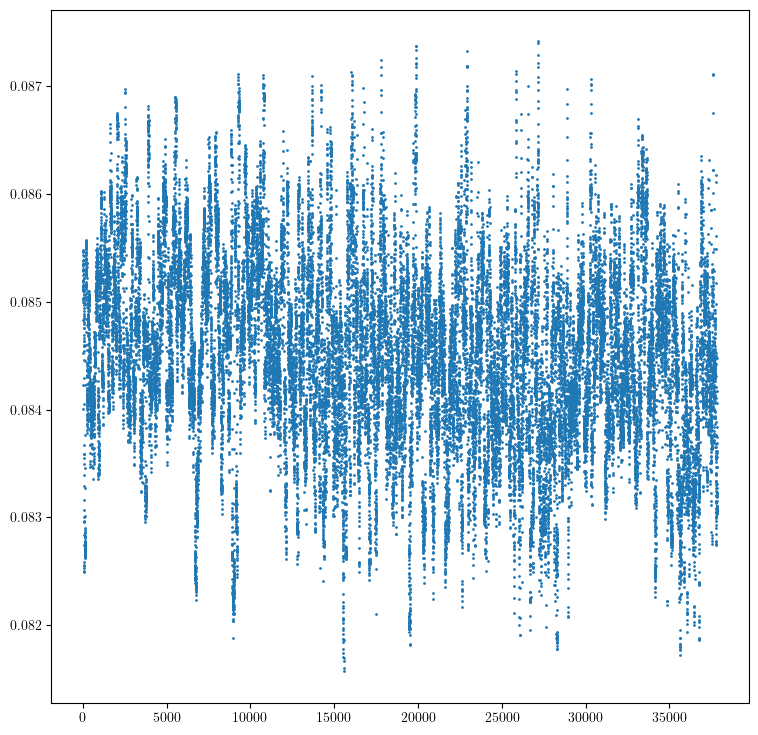

In [40]:
ys = np.convolve(oog.delta_phases, np.ones(oog.sequence_manager.reference_sequence.shape[0])/oog.sequence_manager.reference_sequence.shape[0])[100:-100]
xs = np.arange(len(ys))

plt.scatter(xs, ys, s = 1)
plt.show()

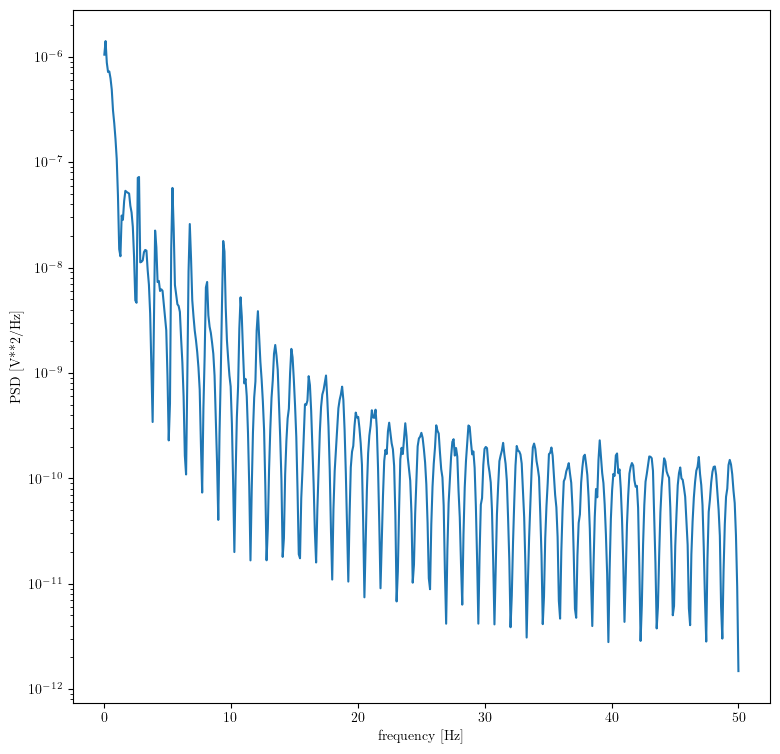

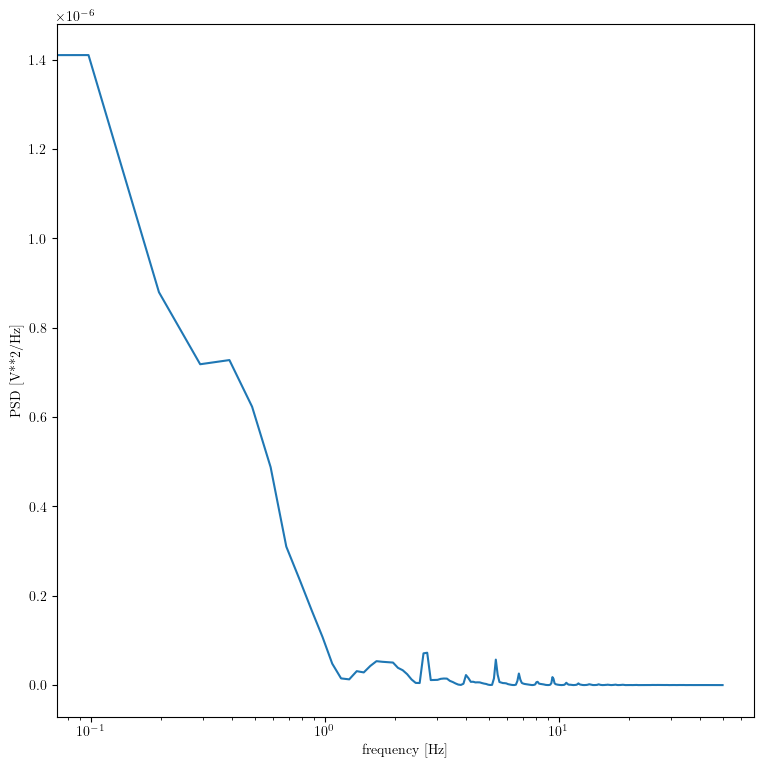

In [56]:
from scipy import signal
fs = 10e1
f, Pxx_den = signal.welch(np.convolve(oog.delta_phases, np.ones(oog.sequence_manager.reference_sequence.shape[0])/oog.sequence_manager.reference_sequence.shape[0]), fs, nperseg=1024)
plt.semilogy(f, Pxx_den)
#plt.xscale("log")
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

plt.plot(f, Pxx_den)
plt.xscale("log")
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()


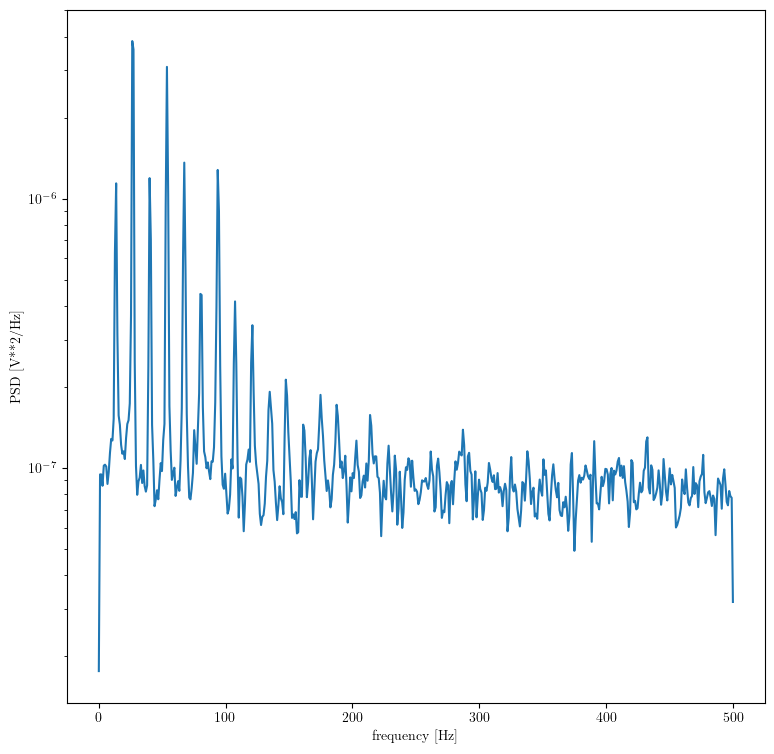

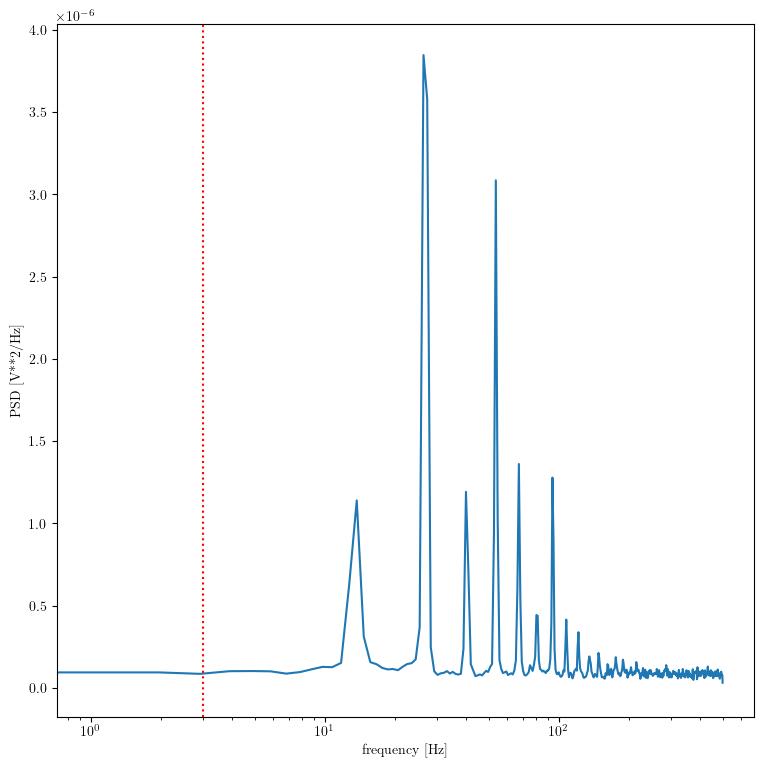

In [57]:
from scipy import signal
fs = 10e2
f, Pxx_den = signal.welch(oog.delta_phases, fs, nperseg=1024)

plt.semilogy(f, Pxx_den)
#plt.xscale("log")
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

plt.plot(f, Pxx_den)
plt.xscale("log")
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.axvline(3, c = "red", ls = ":")
plt.show()
